Setup 1: Mount to drive
> 添加区块引用符号



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setup 2: Install nimblephysics

In [2]:
%cd /content/drive/MyDrive/locodata/InferBiomechanics
!pip3 install -r requirements.txt


/content/drive/MyDrive/locodata/InferBiomechanics
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvid

Setup 3: Install other libraries

In [3]:
!pip install pandas pyarrow
!pip install pandas fastparquet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.1 MB/s eta 0:00:00


Setup 4: Import and set dir

In [4]:
import os
import pandas as pd
from tqdm import tqdm
import nimblephysics as nimble
import matplotlib.pyplot as plt
import fastparquet as fp
import os

# Define the base directory
base_dir = '/content/drive/MyDrive/locodata/addb_dataset_publication/train/No_Arm'
output_dir='/content/drive/MyDrive/locodata/addoutput'

Set chunksize for pipeline.

In [5]:
chunksize=100000

Print the names of all datasets in the folder

In [29]:
import os
import pandas as pd
from tqdm import tqdm
import nimblephysics as nimble

import fastparquet as fp
import os

# Define the base directory
base_dir = '/content/drive/MyDrive/locodata/addb_dataset_publication/train/No_Arm'
output_dir='/content/drive/MyDrive/locodata/addoutput'
# Loop through each dataset in the base directory
dataset_count=0
for dataset in os.listdir(base_dir):

  dataset_count+=1
  if dataset_count>1:
    print(dataset_count,dataset)

2 Wang2023_Formatted_No_Arm
3 vanderZee2022_Formatted_No_Arm
4 Tiziana2019_Formatted_No_Arm
5 Tan2022_Formatted_No_Arm
6 Tan2021_Formatted_No_Arm
7 Santos2017_Formatted_No_Arm
8 Moore2015_Formatted_No_Arm
9 Han2023_Formatted_No_Arm
10 Hamner2013_Formatted_No_Arm
11 Fregly2012_Formatted_No_Arm
12 Falisse2017_Formatted_No_Arm
13 Camargo2021_Formatted_No_Arm


Define the rotation function

In [30]:
import numpy as np

def osim_rotate_matrix(x, y, z):
    """
    Generate a rotation matrix given Euler angles (x, y, z).

    Parameters:
    x (float): Rotation around the x-axis in radians.
    y (float): Rotation around the y-axis in radians.
    z (float): Rotation around the z-axis in radians.

    Returns:
    np.ndarray: A 3x3 rotation matrix.
    """

    # Rotation matrix around the x-axis
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(x), -np.sin(x)],
                    [0, np.sin(x), np.cos(x)]])

    # Rotation matrix around the y-axis
    R_y = np.array([[np.cos(y), 0, np.sin(y)],
                    [0, 1, 0],
                    [-np.sin(y), 0, np.cos(y)]])

    # Rotation matrix around the z-axis
    R_z = np.array([[np.cos(z), -np.sin(z), 0],
                    [np.sin(z), np.cos(z), 0],
                    [0, 0, 1]])

    # Combined rotation matrix
    R = np.dot(R_z, np.dot(R_x, R_y))

    return R




Main transform

In [39]:
import os

# Define the base directory
base_dir = '/content/drive/MyDrive/locodata/addb_dataset_publication/train/No_Arm'
output_dir='/content/drive/MyDrive/locodata/addoutput'
# Loop through each dataset in the base directory
dataset_count=0
for dataset in os.listdir(base_dir):

  dataset_count+=1
  #Pick dataset to process
  if dataset_count==13:
    print(dataset_count,dataset)

    if dataset_count>13:
      break
    dataset_path = os.path.join(base_dir, dataset)
    data=[]
    is_first_chunk = True
    # Check if it's a directory
    if os.path.isdir(dataset_path):

        # Loop through each subject in the dataset
        for subject in tqdm(os.listdir(dataset_path)):
            subject_path = os.path.join(dataset_path, subject)

            # Check if it's a directory
            if os.path.isdir(subject_path):
                # Look for the b3d file in the subject's folder
                for file in os.listdir(subject_path):
                    if file.endswith('.b3d'):#&file.startswith("AB09"):
                        b3d_file_path = os.path.join(subject_path, file)


                        #print(f"Processing {b3d_file_path}")
                        # specific processing code here
                        #try:
                        accum_time=0

                        # Create a SubjectOnDisk object
                        my_subject = nimble.biomechanics.SubjectOnDisk(b3d_file_path)

                        #print(my_subject.
                        num_trial=my_subject.getNumTrials()
                        for trial_turn in range(num_trial):
                          #ff is the frames for a single piece of task
                          ff=my_subject.readFrames(trial_turn,0,20000)
                          task=my_subject.getTrialOriginalName(trial_turn)# task name
                          time_interval=my_subject.getTrialTimestep(trial_turn)
                          # iterate through every frame
                          for i,a in enumerate(ff):

                            ss=a.processingPasses[1] # ss is a single frame of information
                            #acc=ss.acc
                            grf=(ss.groundContactForce)
                            cop=(ss.groundContactCenterOfPressureInRootFrame)
                            cop_org=ss.groundContactCenterOfPressureInRootFrame
                            contacted=ss.contact
                            poses=ss.pos
                            vels=ss.vel
                            tau=ss.tau
                            # Assigning variables to poses array elements
                            pelvis_angle_s = poses[0]
                            pelvis_angle_f = poses[1]
                            pelvis_angle_t = poses[2]
                            hip_angle_s_r = poses[6]
                            hip_angle_f_r = poses[7]
                            hip_angle_t_r = poses[8]
                            knee_angle_s_r = poses[9]
                            ankle_angle_s_r = poses[10]
                            ankle_angle_t_r = poses[11]

                            hip_angle_s_l = poses[13]
                            hip_angle_f_l = poses[14]
                            hip_angle_t_l = poses[15]
                            knee_angle_s_l = poses[16]
                            ankle_angle_s_l = poses[17]
                            ankle_angle_t_l = poses[18]

                            pelvis_vel_s = vels[0]
                            pelvis_vel_f = vels[1]
                            pelvis_vel_t = vels[2]
                            hip_vel_s_r = vels[6]
                            hip_vel_f_r = vels[7]
                            hip_vel_t_r = vels[8]
                            knee_vel_s_r = vels[9]
                            ankle_vel_s_r = vels[10]
                            ankle_vel_t_r = vels[11]
                            hip_vel_s_l = vels[13]
                            hip_vel_f_l = vels[14]
                            hip_vel_t_l = vels[15]
                            knee_vel_s_l = vels[16]
                            ankle_vel_s_l = vels[17]
                            ankle_vel_t_l = vels[18]

                            pelvis_tau_s = ss.tau[0]
                            pelvis_tau_f = ss.tau[1]
                            pelvis_tau_t = ss.tau[2]
                            hip_tau_s_r = ss.tau[6]
                            hip_tau_f_r = ss.tau[7]
                            hip_tau_t_r = ss.tau[8]
                            knee_tau_s_r = ss.tau[9]
                            ankle_tau_s_r = ss.tau[10]
                            ankle_tau_t_r = ss.tau[11]
                            hip_tau_s_l = ss.tau[13]
                            hip_tau_f_l = ss.tau[14]
                            hip_tau_t_l = ss.tau[15]
                            knee_tau_s_l = ss.tau[16]
                            ankle_tau_s_l = ss.tau[17]
                            ankle_tau_t_l = ss.tau[18]


                            R_pelvis=osim_rotate_matrix(pelvis_angle_f,pelvis_angle_t,pelvis_angle_s)
                            R_hip_r=osim_rotate_matrix(hip_angle_f_r,hip_angle_t_r,hip_angle_s_r)
                            R_hip_l=osim_rotate_matrix(hip_angle_f_l,hip_angle_t_l,hip_angle_s_l)
                            R_knee_r=osim_rotate_matrix(0,0,-knee_angle_s_r)
                            R_knee_l=osim_rotate_matrix(0,0,-knee_angle_s_l)
                            R_ankle_r=osim_rotate_matrix(0,ankle_angle_t_r,ankle_angle_s_r)
                            R_ankle_l=osim_rotate_matrix(0,ankle_angle_t_l,ankle_angle_s_l)





                            R_right_shank_all=np.dot(R_pelvis,np.dot(R_hip_r,(R_knee_r)))
                            R_left_shank_all=np.dot(R_pelvis,np.dot(R_hip_l,R_knee_l))
                            shank_angle_r=R_right_shank_all[1,0]
                            shank_angle_l=R_left_shank_all[1,0]
                            if i==0:
                              prev_shank_angle_r=shank_angle_r
                            if i==0:
                              prev_shank_angle_l=shank_angle_l
                            shank_vel_r=(shank_angle_r-prev_shank_angle_r)/time_interval
                            shank_vel_l=(shank_angle_l-prev_shank_angle_l)/time_interval
                            prev_shank_angle_r=shank_angle_r
                            prev_shank_angle_l=shank_angle_l

                            R_right_thigh_all=np.dot(R_pelvis,R_hip_r)
                            R_left_thigh_all=np.dot(R_pelvis,R_hip_l)
                            thigh_angle_r=R_right_thigh_all[1,0]
                            thigh_angle_l=R_left_thigh_all[1,0]
                            if i==0:
                              prev_thigh_angle_r=thigh_angle_r
                            if i==0:
                              prev_thigh_angle_l=thigh_angle_l
                            thigh_vel_l=(thigh_angle_l-prev_thigh_angle_l)/time_interval
                            thigh_vel_r=(thigh_angle_r-prev_thigh_angle_r)/time_interval
                            prev_thigh_angle_r=thigh_angle_r
                            prev_thigh_angle_l=thigh_angle_l



                            R_right_foot_all=np.dot(R_pelvis,np.dot(R_hip_r,np.dot(R_knee_r,R_ankle_r)))
                            R_left_foot_all=np.dot(R_pelvis,np.dot(R_hip_l,np.dot(R_knee_l,R_ankle_l)))
                            dorsi_angle_r=R_right_foot_all[1,0]
                            dorsi_angle_l=R_left_foot_all[1,0]
                            if i==0:
                              prev_dorsi_angle_r=dorsi_angle_r
                            if i==0:
                              prev_dorsi_angle_l=dorsi_angle_l
                            ankle_vel_r=(dorsi_angle_r-prev_dorsi_angle_r)/time_interval
                            ankle_vel_l=(dorsi_angle_l-prev_dorsi_angle_l)/time_interval
                            prev_dorsi_angle_r=dorsi_angle_r
                            prev_dorsi_angle_l=dorsi_angle_l



                            t=i

                            record = {
                                  'subject': file.split('.')[0] ,
                                  'task': task,
                                  'time_step': t,
                                  'accum_time': accum_time,

                                  'contact_r': contacted[0],
                                  'contact_l': contacted[1],

                                  'GRF_x_r': grf[0],
                                  'GRF_y_r': grf[1],
                                  'GRF_z_r': grf[2],
                                  'GRF_x_l': grf[3],
                                  'GRF_y_l': grf[4],
                                  'GRF_z_l': grf[5],
                                  'COP_x_r': cop[0],
                                  'COP_y_r': cop[1],
                                  'COP_z_r': cop[2],
                                  'COP_x_l': cop[3],
                                  'COP_y_l': cop[4],
                                  'COP_z_l': cop[5],

                                  'pelvis_angle_s': pelvis_angle_s,
                                  'pelvis_angle_f': pelvis_angle_f,
                                  'pelvis_angle_t': pelvis_angle_t,


                                  'hip_angle_s_r': hip_angle_s_r,
                                  'hip_angle_f_r': hip_angle_f_r,
                                  'hip_angle_t_r': hip_angle_t_r,
                                  'knee_angle_s_r': knee_angle_s_r,
                                  'ankle_angle_s_r': ankle_angle_s_r,
                                  # 'ankle_angle_f_r': ankle_angle_f_r,
                                  'ankle_angle_t_r': ankle_angle_t_r,
                                  'hip_angle_s_l': hip_angle_s_l,
                                  'hip_angle_f_l': hip_angle_f_l,
                                  'hip_angle_t_l': hip_angle_t_l,
                                  'knee_angle_s_l': knee_angle_s_l,
                                  'ankle_angle_s_l': ankle_angle_s_l,
                                  # 'ankle_angle_f_l': ankle_angle_f_l,
                                  'ankle_angle_t_l': ankle_angle_t_l,
                                  'dorsi_angle_r': dorsi_angle_r,
                                  'dorsi_angle_l': dorsi_angle_l,
                                  'shank_angle_r': shank_angle_r,
                                  'shank_angle_l': shank_angle_l,
                                  'thigh_angle_r': thigh_angle_r,
                                  'thigh_angle_l': thigh_angle_l,

                                  'shank_vel_r': shank_vel_r,
                                  'shank_vel_l': shank_vel_l,
                                  'thigh_vel_r': thigh_vel_r,
                                  'thigh_vel_l': thigh_vel_l,
                                  'ankle_vel_r': ankle_vel_r,
                                  'ankle_vel_l': ankle_vel_l,

                                  'pelvis_vel_s': pelvis_vel_s,
                                  'pelvis_vel_f': pelvis_vel_f,
                                  'pelvis_vel_t': pelvis_vel_t,
                                  'hip_vel_s_r': hip_vel_s_r,
                                  'hip_vel_f_r': hip_vel_f_r,
                                  'hip_vel_t_r': hip_vel_t_l,
                                  'knee_vel_s_r': knee_vel_s_r,
                                  'ankle_vel_s_r': ankle_vel_s_r,
                                  'ankle_vel_t_r': ankle_vel_t_r,
                                  'hip_vel_s_l': hip_vel_s_l,
                                  'hip_vel_f_l': hip_vel_f_l,
                                  'hip_vel_t_l': hip_vel_t_l,
                                  'knee_vel_s_l': knee_vel_s_l,
                                  'ankle_vel_s_l': ankle_vel_s_l,
                                  'ankle_vel_t_l': ankle_vel_t_l,

                                  'pelvis_tau_s': pelvis_tau_s,
                                  'pelvis_tau_f': pelvis_tau_f,
                                  'pelvis_tau_t': pelvis_tau_t,
                                  'hip_tau_s_r': hip_tau_s_r,
                                  'hip_tau_f_r': hip_tau_f_r,
                                  'hip_tau_t_r': hip_tau_t_r,
                                  'knee_tau_s_r': knee_tau_s_r,
                                  'ankle_tau_s_r': ankle_tau_s_r,
                                  'ankle_tau_t_r': ankle_tau_t_r,
                                  'hip_tau_s_l': hip_tau_s_l,
                                  'hip_tau_f_l': hip_tau_f_l,
                                  'hip_tau_t_l': hip_tau_t_l,
                                  'knee_tau_s_l': knee_tau_s_l,
                                  'ankle_tau_s_l': ankle_tau_s_l,



                              }
                            accum_time+=time_interval

                              # Add the record to the data list
                            data.append(record)
                            #print(ss.groundContactForce)
                          #print(ss.groundContactCenterOfPressure)
                          if len(data)>=chunksize:

                            df = pd.DataFrame(data)

                            # Save the DataFrame to a Parquet file
                            output_path = os.path.join(output_dir, dataset+'.parquet')
                            df.to_parquet(output_path, engine='fastparquet',index=False,append=not is_first_chunk)
                            is_first_chunk=False
                            data=[]
                        # finally:
                        #   continue





        df = pd.DataFrame(data)
        print(len(data))
        # Save the DataFrame to a Parquet file
        output_path = os.path.join(output_dir, dataset+'.parquet')
        df.to_parquet(output_path, engine='fastparquet',index=False,append=not is_first_chunk)

        #print(f"Data saved to {output_path}")

13 Camargo2021_Formatted_No_Arm


100%|██████████| 120/120 [2:14:36<00:00, 67.30s/it]


9237


In [ ]:
print(dir(ss.jointCenters))

['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdivmod__', '__reduce__', '

In [ ]:
print(ss.rootLinearVelInRootFrame)

[-0.03557674 -0.09928568  0.00472122]


pelvis hip_r
knee_r ankle_r
subtalar_r mtp_r

hl kl
al sl
ml back

In [ ]:
print(ss.jointCentersInRootFrame)

[ 0.          0.          0.         -0.05751366 -0.08004515  0.08661167
 -0.19961217 -0.48842456  0.0758983  -0.36886249 -0.88001521  0.06563894
 -0.43807356 -0.90653119  0.06937882 -0.26602353 -0.97040764  0.09034758
 -0.05751366 -0.08004515 -0.08661167  0.03113158 -0.49862114 -0.14138993
 -0.10317601 -0.90365896 -0.14136345 -0.17504786 -0.92194832 -0.14404517
 -0.01224985 -1.00112838 -0.18076615 -0.10291467  0.08311478  0.        ]


In [ ]:
print(ss.pos)

[ 0.18401251  0.01476954  0.08060064  0.78801604  1.0103333   0.57603525
 -0.31673829  0.01615001 -0.09584595  0.08509548  0.0565546  -0.04458963
  0.          0.22096413 -0.13690887 -0.19249633  0.54438969 -0.15578456
 -0.18105579  0.         -0.4781786  -0.03221183  0.05344516]


In [ ]:
dir(ss.pos)

NameError: name 'ss' is not defined

In [ ]:
print(ss.jointCenters-ss.jointCentersInRootFrame)

[1.72164677 0.87051827 0.24243658 1.71120254 0.87871945 0.24173136
 1.69595441 0.88049074 0.25730588 1.68395923 0.88721666 0.26087905
 1.6826702  0.89041527 0.25723356 1.67886083 0.88263287 0.27451072
 1.72390787 0.8687876  0.24251629 1.70779855 0.85999693 0.27632312
 1.68921268 0.85492032 0.30708299 1.68576486 0.85726514 0.30744022
 1.69072079 0.84671797 0.318607   1.72667216 0.87560979 0.22806694]


In [ ]:
import pandas as pd

In [ ]:
import os

# Define the base directory
base_dir = '/content/drive/MyDrive/locodata/addb_dataset_publication/train/No_Arm'
output_dir='/content/drive/MyDrive/locodata/addoutput'

In [38]:
df = pd.read_parquet(os.path.join(output_dir, 'Tan2022_Formatted_No_Arm'+'.parquet'))
print(df.columns)
df

Index(['subject', 'task', 'time_step', 'accum_time', 'contact_r', 'contact_l',
       'GRF_x_r', 'GRF_y_r', 'GRF_z_r', 'GRF_x_l', 'GRF_y_l', 'GRF_z_l',
       'COP_x_r', 'COP_y_r', 'COP_z_r', 'COP_x_l', 'COP_y_l', 'COP_z_l',
       'pelvis_angle_s', 'pelvis_angle_f', 'pelvis_angle_t', 'hip_angle_s_r',
       'hip_angle_f_r', 'hip_angle_t_r', 'knee_angle_s_r', 'ankle_angle_s_r',
       'ankle_angle_t_r', 'hip_angle_s_l', 'hip_angle_f_l', 'hip_angle_t_l',
       'knee_angle_s_l', 'ankle_angle_s_l', 'ankle_angle_t_l', 'dorsi_angle_r',
       'dorsi_angle_l', 'shank_angle_r', 'shank_angle_l', 'thigh_angle_r',
       'thigh_angle_l', 'shank_vel_r', 'shank_vel_l', 'thigh_vel_r',
       'thigh_vel_l', 'ankle_vel_r', 'ankle_vel_l', 'pelvis_vel_s',
       'pelvis_vel_f', 'pelvis_vel_t', 'hip_vel_s_r', 'hip_vel_f_r',
       'hip_vel_t_r', 'knee_vel_s_r', 'ankle_vel_s_r', 'ankle_vel_t_r',
       'hip_vel_s_l', 'hip_vel_f_l', 'hip_vel_t_l', 'knee_vel_s_l',
       'ankle_vel_s_l', 'ankle_vel_t_l', 

,subject,task,time_step,accum_time,contact_r,contact_l,GRF_x_r,GRF_y_r,GRF_z_r,GRF_x_l,...,hip_tau_f_r,hip_tau_t_r,knee_tau_s_r,ankle_tau_s_r,ankle_tau_t_r,hip_tau_s_l,hip_tau_f_l,hip_tau_t_l,knee_tau_s_l,ankle_tau_s_l
0,17,baseline,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,17,baseline,1,0.009999,1,1,0.690252,390.396487,-23.969711,2.664220,...,-67.103041,2.198379,-16.290931,-3.886348,1.787373,6.821611,56.813586,-1.592388,-9.809206,-6.355920
2,17,baseline,2,0.019998,1,1,0.610330,389.820503,-23.741818,3.547968,...,-65.559275,1.967809,-16.254069,-3.636193,1.824949,7.705767,54.201353,-1.594084,-9.536190,-6.382769
3,17,baseline,3,0.029998,1,1,0.504910,389.289481,-23.556708,4.109151,...,-64.765619,1.891240,-16.457335,-3.459021,1.913828,7.190242,54.622797,-1.482992,-9.415551,-6.007181
4,17,baseline,4,0.039997,1,1,0.372610,388.812893,-23.403347,4.392834,...,-64.798219,1.903094,-16.725380,-3.419459,2.010421,6.929312,55.275840,-1.414368,-9.891322,-5.387322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490860,15,trunk_sway,1041,931.500018,1,0,2.233066,554.659981,-59.702496,0.000000,...,-92.416324,-1.968123,5.481986,-54.428415,9.921219,-19.358512,35.697782,-5.201900,8.063208,-0.129816
1490861,15,trunk_sway,1042,931.510018,1,0,4.604127,559.453774,-59.689744,0.000000,...,-89.659240,-2.652995,12.534661,-57.438793,10.553278,0.959854,42.194325,-7.536732,-3.028744,0.458709
1490862,15,trunk_sway,1043,931.520018,1,0,7.348869,566.033969,-59.584340,0.000000,...,-85.883833,-3.045077,17.878368,-60.544945,11.235275,13.454104,44.638626,-8.253904,-9.789526,1.027922
1490863,15,trunk_sway,1044,931.530017,1,0,9.448136,571.480227,-59.503313,0.000000,...,-96.266138,-3.195028,-16.668898,-63.195993,11.932156,-120.295284,36.863383,2.131753,64.451851,-2.681831


In [ ]:
df = pd.read_parquet(os.path.join(output_dir, 'Camargo2021_Formatted_No_Arm'+'.parquet'))
print(df.columns)
df

In [ ]:
df

,subject,task,time_step,contact_r,contact_l,GRF_x_r,GRF_y_r,GRF_z_r,GRF_x_l,GRF_y_l,...,ankle_angle_s_r,ankle_angle_t_r,hip_angle_s_l,hip_angle_f_l,hip_angle_t_l,knee_angle_s_l,ankle_angle_s_l,ankle_angle_t_l,dorsi_angle_r,dorsi_angle_l
0,AB09,stair_1_l_01,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.182550,0.018466,0.184374,0.042396,-0.051168,0.144457,0.128577,0.039227,-0.013656,-0.003853
1,AB09,stair_1_l_01,1,0,0,0.0,0.0,0.0,0.0,0.0,...,0.184615,0.018200,0.184429,0.043329,-0.052047,0.145229,0.129101,0.036730,-0.015015,-0.004446
2,AB09,stair_1_l_01,2,0,0,0.0,0.0,0.0,0.0,0.0,...,0.185915,0.015260,0.184646,0.043609,-0.053304,0.145214,0.129723,0.036741,-0.017368,-0.004247
3,AB09,stair_1_l_01,3,0,0,0.0,0.0,0.0,0.0,0.0,...,0.187333,0.011157,0.185069,0.043687,-0.054544,0.145577,0.129638,0.035173,-0.019394,-0.004907
4,AB09,stair_1_l_01,4,0,0,0.0,0.0,0.0,0.0,0.0,...,0.188801,0.007941,0.185408,0.044348,-0.055514,0.146167,0.129891,0.033458,-0.021813,-0.005446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267447,AB23,ramp_3_r_01,349,0,0,0.0,0.0,0.0,0.0,0.0,...,0.108405,-0.203929,0.225794,0.011358,-0.108490,0.290162,0.050295,-0.349066,-0.040562,-0.086610
9267448,AB23,ramp_3_r_01,350,0,0,0.0,0.0,0.0,0.0,0.0,...,0.109021,-0.202756,0.221884,0.012579,-0.111724,0.285520,0.050732,-0.349066,-0.042173,-0.086947
9267449,AB23,ramp_3_r_01,351,0,0,0.0,0.0,0.0,0.0,0.0,...,0.109796,-0.200843,0.219397,0.013873,-0.115308,0.280865,0.050903,-0.349066,-0.043532,-0.087534
9267450,AB23,ramp_3_r_01,352,0,0,0.0,0.0,0.0,0.0,0.0,...,0.110722,-0.199807,0.217040,0.015447,-0.119115,0.276284,0.050130,-0.349066,-0.044662,-0.089189


In [ ]:
df['subject'] = df['subject'].str.replace(r'(_.*)$', '', regex=True)
df['task'] = df['task'].str.replace(r'_..$', '', regex=True)

In [ ]:
print(df.columns)

Index(['subject', 'task', 'time_step', 'contact_r', 'contact_l', 'GRF_x_r',
       'GRF_y_r', 'GRF_z_r', 'GRF_x_l', 'GRF_y_l', 'GRF_z_l', 'COP_x_r',
       'COP_y_r', 'COP_z_r', 'COP_x_l', 'COP_y_l', 'COP_z_l', 'pelvis_angle_s',
       'pelvis_angle_f', 'pelvis_angle_t', 'hip_angle_s_r', 'hip_angle_f_r',
       'hip_angle_t_r', 'knee_angle_s_r', 'ankle_angle_s_r', 'ankle_angle_t_r',
       'hip_angle_s_l', 'hip_angle_f_l', 'hip_angle_t_l', 'knee_angle_s_l',
       'ankle_angle_s_l', 'ankle_angle_t_l', 'dorsi_angle_r', 'dorsi_angle_l',
       'shank_angle_r', 'shank_angle_l', 'thigh_angle_r', 'thigh_angle_l',
       'pelvis_vel_s', 'pelvis_vel_f', 'pelvis_vel_t', 'hip_vel_s_r',
       'hip_vel_f_r', 'hip_vel_t_r', 'knee_vel_s_r', 'ankle_vel_s_r',
       'ankle_vel_t_r', 'hip_vel_s_l', 'hip_vel_f_l', 'hip_vel_t_l',
       'knee_vel_s_l', 'ankle_vel_s_l', 'ankle_vel_t_l', 'pelvis_tau_s',
       'pelvis_tau_f', 'pelvis_tau_t', 'hip_tau_s_r', 'hip_tau_f_r',
       'hip_tau_t_r', 'knee_tau_s

In [ ]:
import numpy as np

def ddt(x, incr=1):
    """
    Approximates the derivative of the input x by fitting a parabola to five points and using its analytical derivative.

    Parameters:
    x : array-like
        Input array of data points.
    incr : float, optional
        Increment value, default is 1.

    Returns:
    dx : ndarray
        The derivative of x.
    """
    x = np.asarray(x)
    xr, xc = x.shape if x.ndim > 1 else (x.size, 1)

    if xc > 1:
        # Process each column
        dx = np.zeros_like(x)
        for i in range(xc):
            dx[:, i] = ddt(x[:, i], incr)
        return dx

    # Perform 2-sided filtering
    dx = filter22(np.array([-2, -1, 0, 1, 2]), x, 2)
    dx = -dx / (10. * incr)

    m = len(x)
    dx[0] = (-21. * x[0] + 13. * x[1] + 17. * x[2] - 9. * x[3]) / (20. * incr)
    dx[1] = (-11. * x[0] + 3. * x[1] + 7. * x[2] + x[3]) / (20. * incr)
    dx[m-1] = (11. * x[m-1] - 3. * x[m-2] - 7. * x[m-3] - x[m-4]) / (20. * incr)
    dx[m-2] = (21. * x[m-1] - 13. * x[m-2] - 17. * x[m-3] + 9. * x[m-4]) / (20. * incr)

    return dx

def filter22(fil, x, numsides):
    """
    Performs 2-sided as well as one-sided filtering.

    Parameters:
    fil : array-like
        Filter coefficients.
    x : array-like
        Input array.
    numsides : int
        Number of sides for filtering (1 for one-sided, 2 for two-sided).

    Returns:
    y : ndarray
        The filtered array.
    """
    x = np.asarray(x)
    if x.ndim > 1:
        x = x.flatten()

    numpts = len(x)
    halflen = int(np.ceil(len(fil) / 2))

    if numsides == 2:
        x = np.concatenate((x, np.zeros(halflen)))
        y = np.convolve(x, fil, mode='same')
        y = y[halflen:numpts + halflen]
    else:
        y = np.convolve(x, fil, mode='full')[:numpts]

    return y


In [ ]:
# Assuming your DataFrame is named `df`
unique_tasks = df['task'].unique()

# Print all the unique tags
print("Unique tags in the 'task' column:")
for task in unique_tasks:
    print(task)


Unique tags in the 'task' column:
stair_1_l_01
stair_1_r_01
stair_2_l_01
stair_2_r_01
stair_3_l_01
stair_3_r_01
stair_4_l_01
stair_4_r_01
ramp_4_l_01
ramp_4_r_01
ramp_5_l_01
ramp_5_r_01
ramp_6_l_01
ramp_6_l_02
ramp_6_r_01
ramp_6_r_02
levelground_cw_fast_01
levelground_cw_normal_01
levelground_cw_normal_02
levelground_cw_slow_01
levelground_cw_slow_02
Ramp_2_R_01
ramp_1_l_01
ramp_1_r_01
ramp_1_r_02
ramp_2_l_01
ramp_3_l_01
ramp_3_r_01
ramp_3_r_02
treadmill_01
treadmill_02
treadmill_03
treadmill_04
treadmill_05
treadmill_06
treadmill_07
levelground_ccw_fast_01
levelground_ccw_normal_01
levelground_ccw_slow_01
levelground_ccw_slow_02


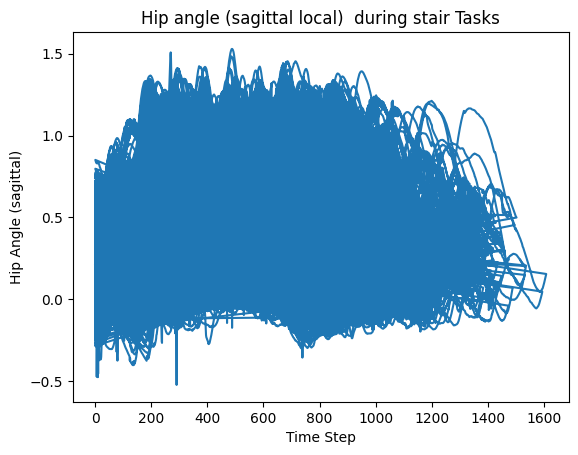

SD: 0.2918463893076317
Mean: 0.4214692404584061


In [ ]:
import matplotlib.pyplot as plt

# Filter the DataFrame for subject AB01 and tasks starting with "treadmill"
#filtered_df = df[(df['subject'] == 'AB11') & (df['task'].str.startswith('treadmill'))]
filtered_df = df[ (df['task'].str.startswith('stair'))]
#filtered_df = df[(df['task'].str.startswith('treadmill'))|(df['task'].str.startswith('levelground'))]

task_name="hip_angle_s_r"
# Plotting pelvis_angle_s for AB01 with tasks starting with "treadmill"
plt.plot(filtered_df['time_step'].to_numpy(), filtered_df[task_name].to_numpy())
plt.xlabel('Time Step')
plt.ylabel('Hip Angle (sagittal)')
plt.title('Hip angle (sagittal local)  during stair Tasks')
plt.grid(False)
plt.show()
print("SD:",filtered_df[task_name].std())
print("Mean:",filtered_df[task_name].mean())

In [18]:
filtered_df=df[(df['task']=='treadmill_01_01')&( df['subject']=='AB09_split5')]
print(filtered_df['subject'].unique())

['AB09_split5']


In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt



# Define the filter parameters
order = 4      # Order of the filter
cutoff = 3.0   # Desired cutoff frequency of the filter, Hz
fs = 50.0      # Sampling frequency of the signal, Hz

# Design the Butterworth low-pass filter
nyquist = 0.5 * fs  # Nyquist frequency
normal_cutoff = cutoff / nyquist  # Normalize the frequency
b, a = butter(order, normal_cutoff, btype='low', analog=False)

# Apply the filter to the signal
filtered_signal = filtfilt(b, a, signal)

# Now, filtered_signal contains the low-pass filtered version of the original signal


In [ ]:
import matplotlib.pyplot as plt

# Filter the DataFrame for the specific subject and task
filtered_df = df[(df['subject'] == 'AB09') & (df['task'] == 'treadmill_01')]

# Extract the right and left dorsi angles
dorsi_angle_r = filtered_df['dorsi_angle_r'].to_numpy()
dorsi_angle_l = filtered_df['dorsi_angle_l'].to_numpy()
ankle_t=filtered_df['ankle_tau_s_r'].to_numpy()
ankle_vel=filtered_df['ankle_vel_r'].to_numpy()
thigh_angle_r=filtered_df['thigh_angle_r'].to_numpy()
thigh_angle_l=filtered_df['thigh_angle_l'].to_numpy()
hip_tau=filtered_df['hip_tau_s_r'].to_numpy()

import numpy as np
from scipy.signal import butter, filtfilt



# Define the filter parameters
order = 4      # Order of the filter
cutoff = 3   # Desired cutoff frequency of the filter, Hz
fs = 100.0      # Sampling frequency of the signal, Hz

# Design the Butterworth low-pass filter
nyquist = 0.5 * fs  # Nyquist frequency
normal_cutoff = cutoff / nyquist  # Normalize the frequency
b, a = butter(order, normal_cutoff, btype='low', analog=False)

# Apply the filter to the signal
filtered_signal = filtfilt(b, a, ankle_vel)

# Now, filtered_signal contains the low-pass filtered version of the original signal


# Extract the time steps
time_steps = filtered_df['time_step'].to_numpy()

# Plotting
plt.plot(time_steps[0:1000], filtered_signal[0:1000], label='Right Foot Velocity')
#plt.plot(time_steps, dorsi_angle_l, label='Left Ankle Angle')
plt.xlabel('Time Step')
plt.ylabel('Foot velocity')
plt.title('Foot Velocity (Sagittal) for AB09 during Task Treadmill 1 (3Hz)')
plt.legend()
plt.grid(False)
plt.show()


ValueError: The length of the input vector x must be greater than padlen, which is 15.

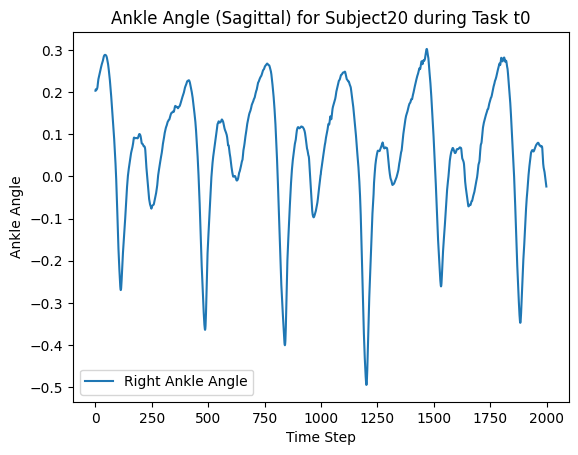

In [28]:
ankle_local=filtered_df['ankle_angle_s_r'].to_numpy( )
time_steps = filtered_df['time_step'].to_numpy()
plt.plot( ankle_local[1000:3000], label='Right Ankle Angle')
#plt.plot(time_steps, dorsi_angle_l, label='Left Ankle Angle')
plt.xlabel('Time Step')
plt.ylabel('Ankle Angle')
plt.title('Ankle Angle (Sagittal) for Subject20 during Task t0')
plt.legend()
plt.grid(False)
plt.show()

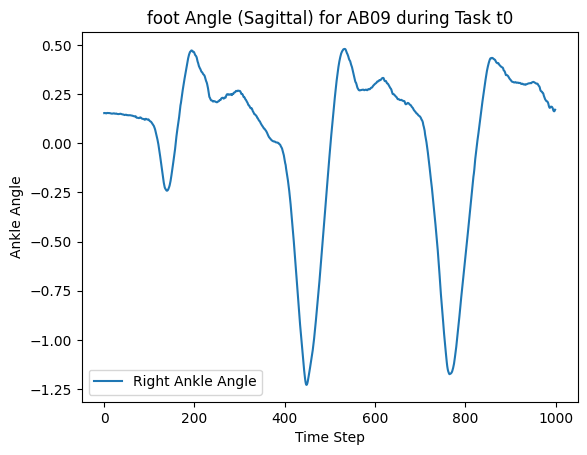

In [ ]:
ankle_local=filtered_df['ankle_angle_s_r'].to_numpy( )-filtered_df['knee_angle_s_r']+filtered_df['hip_angle_s_r'].to_numpy()+filtered_df['pelvis_angle_s'].to_numpy()
plt.plot(time_steps[0:1000], ankle_local[0:1000], label='Right Ankle Angle')
#plt.plot(time_steps, dorsi_angle_l, label='Left Ankle Angle')
plt.xlabel('Time Step')
plt.ylabel('Ankle Angle')
plt.title('foot Angle (Sagittal) for AB09 during Task t0')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
unique_tasks = filtered_df['task'].unique()

# Print all the unique tags
print("Unique tags in the 'task' column:")
for task in unique_tasks:
    print(task)

Unique tags in the 'task' column:
stair_1_l_01_01
stair_1_l_01_02
stair_1_l_01_03
stair_1_l_01_04
stair_1_l_01_05
stair_1_l_01_06
stair_1_r_01_01
stair_1_r_01_02
stair_1_r_01_03
stair_1_r_01_04
stair_1_r_01_05
stair_2_l_01_01
stair_2_l_01_02
stair_2_l_01_03
stair_2_l_01_04
stair_2_l_01_05
stair_2_r_01_01
stair_2_r_01_02
stair_2_r_01_03
stair_2_r_01_04
stair_2_r_01_05
stair_3_l_01_01
stair_3_l_01_02
stair_3_l_01_03
stair_3_l_01_04
stair_3_l_01_05
stair_3_r_01_01
stair_3_r_01_02
stair_3_r_01_03
stair_3_r_01_04
stair_3_r_01_05
stair_4_l_01_01
stair_4_l_01_02
stair_4_l_01_03
stair_4_l_01_04
stair_4_l_01_05
stair_4_r_01_01
stair_4_r_01_02
stair_4_r_01_03
stair_4_r_01_04
stair_4_r_01_05
ramp_4_l_01_01
ramp_4_l_01_02
ramp_4_l_01_03
ramp_4_l_01_04
ramp_4_l_01_05
ramp_4_r_01_01
ramp_4_r_01_02
ramp_4_r_01_03
ramp_4_r_01_04
ramp_4_r_01_05
ramp_5_l_01_01
ramp_5_l_01_02
ramp_5_l_01_03
ramp_5_l_01_04
ramp_5_l_01_05
ramp_5_r_01_01
ramp_5_r_01_02
ramp_5_r_01_03
ramp_5_r_01_04
ramp_5_r_01_05
ramp_6_l_0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector


In [ ]:

# Sample data creation (replace with your actual data)
num_samples = 12  # number of subjects
num_time_steps = 100  # number of time steps
grf_dim = 6  # dimension of grf data
cop_dim = 4  # dimension of cop data

# Assuming grf and cop are your actual data arrays
# Combine GRF data into a single DataFrame
grf_t = df[['GRF_x_l', 'GRF_y_l', 'GRF_z_l', 'GRF_x_r', 'GRF_y_r', 'GRF_z_r']].values


cop_t= df[['COP_x_l', 'COP_y_l', 'COP_x_r', 'COP_y_r']].values


# Combine grf and cop
data = np.concatenate((grf_t, cop_t), axis=-1)  # shape: (num_samples, num_time_steps, grf_dim + cop_dim)




In [ ]:
num_samples = data.shape[0] // 100
reshaped_data = data[:num_samples * 100].reshape((num_samples, 100, 10))

print(reshaped_data.shape)  # Should print (num_samples, 100, 9)

(97517, 100, 10)


In [ ]:
# Build the autoencoder
timesteps = num_time_steps
input_dim = grf_dim + cop_dim
latent_dim = 16  # you can adjust this value

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(reshaped_data, reshaped_data, epochs=50, batch_size=2, shuffle=True)

# Extract the encoder part for feature extraction
encoder = Model(inputs, encoded)
encoded_data = encoder.predict(data)

Epoch 1/50
19747/48759 [===========>..................] - ETA: 28:06 - loss: 36355.9492

KeyboardInterrupt: 

In [ ]:
print(data.shape)
print(encoded_data.shape)

(9751781, 10)


NameError: name 'encoded_data' is not defined

In [ ]:
import pandas as pd


In [ ]:
df_g2023 = pd.read_parquet('/content/drive/MyDrive/gtech_2023_time_jose.parquet')
print(df_g2023.columns)


Index(['time', 'hip_angle_s_r', 'hip_angle_f_r', 'hip_angle_t_r',
       'knee_angle_s_r', 'ankle_angle_s_r', 'ankle_angle_f_r', 'hip_angle_s_l',
       'hip_angle_f_l', 'hip_angle_t_l',
       ...
       'foot_vel_t_l', 'toes_vel_f_l', 'toes_vel_s_l', 'toes_vel_t_l',
       'torso_vel_f', 'torso_vel_s', 'torso_vel_t', 'task_info', 'subject',
       'task'],
      dtype='object', length=112)


In [ ]:
unique_tasks = df_g2023['task'].unique()

# Print all the unique tags
print("Unique tags in the 'task' column:")
for task in unique_tasks:
    print(task)

Unique tags in the 'task' column:
ball_toss
curb_down
curb_up
cutting
dynamic_walk
incline_walk
jump
lift_weight
lunges
meander
normal_walk
obstacle_walk
poses
push
side_shuffle
sit_to_stand
squats
stairs
step_ups
tire_run
tug_of_war
turn_and_step
twister
walk_backward
weighted_walk
None


In [ ]:
!pip install --upgrade numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 33.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
astropy 5.3.4 requires numpy<2,>=1.21, but you have numpy 2.0.0 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 2.0.0 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.0.0 which is incompatible.
ibis-framework 8.0.0 requires numpy<2,>=1, but you have numpy 2.0.0 which is incompatible.
numba 0.58.1 requires numpy<1.27,>=1.22, but you have numpy 2.0.0 which is incompatible.
rmm-cu12 24.4.0 requires numpy<2.0a0,>=1.23, but you have numpy 2.0.0 which is incompatible.
scipy 1.11.4 requires numpy<1.28.0,>=1.21.6

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from sklearn.preprocessing import StandardScaler

# Sample DataFrame creation (replace this with your actual DataFrame loading code)
# Assuming your DataFrame is named df



# Select relevant columns for GRF and COP data
grf_cols = ['GRF_x_r', 'GRF_y_r', 'GRF_z_r', 'GRF_x_l', 'GRF_y_l', 'GRF_z_l']
cop_cols = ['COP_x_r', 'COP_y_r', 'COP_z_r', 'COP_x_l', 'COP_y_l', 'COP_z_l']

# Combine GRF and COP data
grf_data = df[grf_cols].values
cop_data = df[cop_cols].values

# Standardize the data
scaler = StandardScaler()
grf_data_scaled = scaler.fit_transform(grf_data)
cop_data_scaled = scaler.fit_transform(cop_data)

# Reshape data for LSTM (samples, time steps, features)
num_time_steps = len(df)
input_dim = grf_data.shape[1]

grf_data_reshaped = grf_data_scaled.reshape(1, num_time_steps, input_dim)
cop_data_reshaped = cop_data_scaled.reshape(1, num_time_steps, input_dim)

# Define the autoencoder model
latent_dim = 16

inputs = Input(shape=(num_time_steps, input_dim))
encoded = LSTM(latent_dim)(inputs)
decoded = RepeatVector(num_time_steps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(grf_data_reshaped, grf_data_reshaped, epochs=50, batch_size=2, shuffle=True)

# Encode the data
encoder = Model(inputs, encoded)
encoded_grf_data = encoder.predict(grf_data_reshaped)

# Plot encoded features
plt.figure(figsize=(10, 4))
plt.plot(encoded_grf_data[0])
plt.title('Encoded Features (GRF)')
plt.xlabel('Time Step')
plt.ylabel('Encoded Feature Value')
plt.show()

# Reconstruct and compare original vs reconstructed data
reconstructed_grf_data = autoencoder.predict(grf_data_reshaped)

plt.figure(figsize=(12, 6))
for dim in range(input_dim):
    plt.subplot(input_dim // 2, 2, dim + 1)
    plt.plot(df.index, grf_data_scaled[0, :, dim], label='Original')
    plt.plot(df.index, reconstructed_grf_data[0, :, dim], label='Reconstructed', linestyle='dashed')
    plt.title(f'GRF Dimension {dim + 1}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
plt.tight_layout()
plt.show()


ImportError: cannot import name 'intp' from 'numpy._core' (/usr/local/lib/python3.10/dist-packages/numpy/_core/__init__.py)

In [6]:
my_subject = nimble.biomechanics.SubjectOnDisk("/content/drive/MyDrive/locodata/addb_dataset_publication/train/No_Arm/Camargo2021_Formatted_No_Arm/AB11_split0/AB11_split0.b3d")

In [ ]:
print(my_subject.getOpensimFileText(0))

<?xml version="1.0" encoding="UTF-8" ?>
<OpenSimDocument Version="40000">
    <Model name="optimized_scale_and_markers">
        <defaults>
            <ControlLinear name="default">
                <is_model_control>true</is_model_control>
                <extrapolate>true</extrapolate>
                <default_min>-1</default_min>
                <default_max>1</default_max>
                <filter_on>false</filter_on>
                <use_steps>false</use_steps>
                <x_nodes/>
                <min_nodes/>
                <max_nodes/>
                <kp>100</kp>
                <kv>20</kv>
            </ControlLinear>
            <CoordinateActuator name="default">
                <!--Flag indicating whether the force is applied or not. If true the forceis applied to the MultibodySystem otherwise the force is not applied.NOTE: Prior to OpenSim 4.0, this behavior was controlled by the 'isDisabled' property, where 'true' meant that force was not being applied. Thus, if 'is

In [7]:
ff=my_subject.readFrames(1,1,1,1)

In [8]:
for i,a in enumerate(ff):

                              ss=a.processingPasses[1]

In [ ]:
print(len(ss.pos))

In [ ]:
print(len(ss.pos))

23


In [ ]:
print(len(ss.l))

23


In [9]:
dir(ss)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'acc',
 'accFiniteDifferenced',
 'angularResidual',
 'comAcc',
 'comAccInRootFrame',
 'comPos',
 'comVel',
 'contact',
 'groundContactCenterOfPressure',
 'groundContactCenterOfPressureInRootFrame',
 'groundContactForce',
 'groundContactForceInRootFrame',
 'groundContactTorque',
 'groundContactTorqueInRootFrame',
 'groundContactWrenches',
 'groundContactWrenchesInRootFrame',
 'jointCenters',
 'jointCentersInRootFrame',
 'linearResidual',
 'markerMax',
 'markerRMS',
 'pos',
 'posObserved',
 'residualWrenchInRootFrame',
 'rootAngularAccInRootFrame',
 'rootAngularVelInRootFrame',
 'rootEulerHistoryInRootFrame',
 'rootLinearAccInRootFrame',
 'rootLinearVe

In [ ]:
print(ss.tau)

[-5.84400149e+02  1.25273797e+02  1.21597441e+02  5.40650541e+03
 -3.89467238e+02  2.33588600e+03  1.94136024e+02 -5.49692437e+01
 -1.07424663e+00 -3.75631992e+01 -1.29890553e+00  4.51312697e+00
  5.66081876e-01  2.33973562e+02  5.23669345e+01  1.84100502e+00
 -2.67384032e+01  3.25507688e-01  7.31030450e-01  1.74277785e-01
 -9.50357899e+02  1.34191925e+02  1.35621756e+01]


In [ ]:
print(my_subject.getTrialTimestep(5))

0.009999168053244592
